## Commit

Running the cell below copies any local source code modifications into the FlashAttention install directory on the FlashAttention docker image, and then commits the Docker image.

In [375]:
!./build_commit.sh

"docker kill" requires at least 1 argument.
See 'docker kill --help'.

Usage:  docker kill [OPTIONS] CONTAINER [CONTAINER...]

Kill one or more running containers
Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... done
== PyTorch ==

NVIDIA Release 22.12 (build 49968248)
PyTorch Version 1.14.0a0+410ce96

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, J

byte-compiling build/bdist.linux-x86_64/egg/flash_attn/models/gpt.py to gpt.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/models/llama.py to llama.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/models/__init__.py to __init__.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/models/gpt_neox.py to gpt_neox.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/models/gptj.py to gptj.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/models/bert.py to bert.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/models/vit.py to vit.cpython-38.pyc
byte-compiling build/bdist.linux-x86_64/egg/flash_attn/models/opt.py to opt.cpython-38.pyc
creating stub loader for flash_attn_cuda.cpython-38-x86_64-linux-gnu.so
byte-compiling build/bdist.linux-x86_64/egg/flash_attn_cuda.py to flash_attn_cuda.cpython-38.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying flash_attn.egg-info/

## Benchmark automation

Automate calls to run benchmarks using the Docker image.

In [352]:
import os

def parse_causal_benchmark(fn="bench_causal.log"):
    causal_data={}
    with open("bench_causal.log","r") as fp:
        att_type=""
        pass_dir=""
        bypass=0
        time_str=""
        for ln in fp:
            #print(ln)        
            if bypass >1:
                #print("<pass",bypass,">")            
                bypass-=1 #Ignore lines until bypass==1
            elif bypass == 1:
                #Collect runtime measurement
                #print("record")
                time_str=ln.split()[0]
                time_float=float(time_str)
                unit_str=ln.split()[1]
                if "us" in unit_str:
                    #print("Detected us in line:",ln,"att_type:",att_type,"pass_dir:",pass_dir)
                    time_float *= 0.001 # us to ms
                    #print("Resolved to",time_float,"ms")
                causal_data[att_type+pass_dir]=time_float
                bypass=0
                #print(float(time_str))
            else:
                if "MaxMemory" in ln:
                    # Assume attention type has already been determined
                    mem_str=ln.split(":")[1].split("GB")[0]
                    mem_float=float(mem_str)
                    causal_data[att_type+pass_dir+"MaxMemory"]=mem_float
                elif "FlashAttention Triton OWH" in ln:
                    #print("FlashAttention triton owh")
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention Triton OWH"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3            
                elif "FlashAttention Triton OG" in ln:
                    #print("FlashAttention triton og")
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention Triton OG"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3
                elif "FlashAttention Triton" in ln:
                    #print("FlashAttention triton")
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention Triton"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3                
                    #print(att_type)
                    #print(pass_dir)
                elif "FlashAttention" in ln:
                    # Identify attention type and direction for experiment
                    att_type="FlashAttention"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3
                    #print(att_type)
                    #print(pass_dir)
                if "PyTorch Attention" in ln:
                    # Identify attention type and direction for experiment
                    att_type="StandardAttention"
                    pass_dir=ln.split("-")[1][1:].strip()
                    bypass=3
                    #print(att_type)
                    #print(pass_dir)
    return causal_data

def benchmark_causal(cfg={},fn="bench_causal.log"):
    opts=" "
    if "repeats" in cfg:
        opts += " -r " + str(cfg["repeats"])
    if "batch_size" in cfg:
        opts += " -b " + str(cfg["batch_size"])
    if "seqlen" in cfg:
        opts += " -m " + str(cfg["seqlen"])
    if "nheads" in cfg:
        opts += " -e " + str(cfg["nheads"])
    if "headdim" in cfg:
        opts += " -k " + str(cfg["headdim"])
    opts += " "
    
    base_cmd="echo \"PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py\""
    env=" | docker-compose run flashattention "
    outp= " > " + fn
 
    cmd=base_cmd + opts + env + outp
    print(cmd)
    os.system(cmd)
    causal_data=parse_causal_benchmark(fn)
    print(causal_data)
    return causal_data

## Sweep

### RTX 3090 speedup & memory vs sequence length

* batch_size=12
* nheads=12
* From A100 result - headdim=64
* seqlen = 128 - 4096
* Keep repeats=30

Authors' note: "Memory savings are the same as on an A100", "We see slightly higher speedups (between 2.5-4.5x) on the GTX 3090, since memory bandwidth on the GDDR6X is lower than A100 HBM (~900 GB/s vs. ~1.5 TB/s)."

In [369]:
cfg={}
cfg["batch_size"]=12
cfg["nheads"]=12
cfg["headdim"]=64


seqlen=[128,256,512,1024, 2048] #4096 exceeds 3090 24GB memory

res=[]

for sl in seqlen:
    print("seqlen=",sl)
    cfg["seqlen"]=sl
    print("cfg:",cfg)
    res.append(benchmark_causal(cfg))

seqlen= 128
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 128}
echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py"  -b 12 -m 128 -e 12 -k 64  | docker-compose run flashattention  > bench_causal.log


Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-07 01:00:24 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-07 01:00:24 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-07 01:00:28 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-07 01:00:28 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.056380000000000006, 'FlashAttentionBackward pass': 0.11156999999999999, 'FlashAttentionForward + Backward pass': 0.22250999999999999, 'FlashAttentionForward + Backward passMaxMemory': 0.0158212890625, 'StandardAttentionForward pass': 0.25255, 'StandardAttentionBackward pass': 0.25824, 'StandardAttentionForward + Backward pass': 0.58688, 'StandardAttentionForward + Backward passMaxMemory': 0.03956298828125, 'FlashAttention TritonForward pass': 0.22782, 'FlashAttention TritonBackward pass': 0.6180399999999999, 'FlashAttention TritonForward + Backward pass': 0.39400999999999997, 'FlashAttention TritonForward + Backward passMaxMemory': 0.03078173828125, 'FlashAttention Triton OWHForward pass': 0.11591, 'FlashAttention Triton OWHBackward pass': 0.33938, 'FlashAttention Triton OWHForward + Backward pass': 0.85297, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.04517236328125}
seqlen= 256
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'se

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-07 01:00:36 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-07 01:00:36 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-07 01:00:39 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-07 01:00:39 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.12062, 'FlashAttentionBackward pass': 0.22927, 'FlashAttentionForward + Backward pass': 0.35116, 'FlashAttentionForward + Backward passMaxMemory': 0.0326416015625, 'StandardAttentionForward pass': 0.26053, 'StandardAttentionBackward pass': 0.44654000000000005, 'StandardAttentionForward + Backward pass': 0.72077, 'StandardAttentionForward + Backward passMaxMemory': 0.09025048828125, 'FlashAttention TritonForward pass': 0.10595, 'FlashAttention TritonBackward pass': 0.25666000000000005, 'FlashAttention TritonForward + Backward pass': 0.40046, 'FlashAttention TritonForward + Backward passMaxMemory': 0.05406298828125, 'FlashAttention Triton OWHForward pass': 0.11572, 'FlashAttention Triton OWHBackward pass': 0.3058, 'FlashAttention Triton OWHForward + Backward pass': 0.75264, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.08284423828125}
seqlen= 512
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 512}
echo "PYTHONPATH=$PWD pyt

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-07 01:00:48 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-07 01:00:48 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-07 01:00:50 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-07 01:00:50 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.26613, 'FlashAttentionBackward pass': 0.5531699999999999, 'FlashAttentionForward + Backward pass': 0.84088, 'FlashAttentionForward + Backward passMaxMemory': 0.0832822265625, 'StandardAttentionForward pass': 0.7549, 'StandardAttentionBackward pass': 1.29, 'StandardAttentionForward + Backward pass': 2.06, 'StandardAttentionForward + Backward passMaxMemory': 0.24500048828125, 'FlashAttention TritonForward pass': 0.12683, 'FlashAttention TritonBackward pass': 0.5369400000000001, 'FlashAttention TritonForward + Backward pass': 0.69443, 'FlashAttention TritonForward + Backward passMaxMemory': 0.10112548828125, 'FlashAttention Triton OWHForward pass': 0.25233, 'FlashAttention Triton OWHBackward pass': 0.6871900000000001, 'FlashAttention Triton OWHForward + Backward pass': 0.75314, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.15868798828125}
seqlen= 1024
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 1024}
echo "PYTHONPATH=$PW

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-07 01:01:00 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-07 01:01:00 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-07 01:01:03 100:100 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-07 01:01:03 100:100 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 0.65258, 'FlashAttentionBackward pass': 1.56, 'FlashAttentionForward + Backward pass': 2.24, 'FlashAttentionForward + Backward passMaxMemory': 0.1625634765625, 'StandardAttentionForward pass': 2.86, 'StandardAttentionBackward pass': 4.31, 'StandardAttentionForward + Backward pass': 7.2, 'StandardAttentionForward + Backward passMaxMemory': 0.76800048828125, 'FlashAttention TritonForward pass': 0.37021, 'FlashAttention TritonBackward pass': 1.51, 'FlashAttention TritonForward + Backward pass': 1.95, 'FlashAttention TritonForward + Backward passMaxMemory': 0.19025048828125, 'FlashAttention Triton OWHForward pass': 0.36383, 'FlashAttention Triton OWHBackward pass': 1.58, 'FlashAttention Triton OWHForward + Backward pass': 2.02, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.30537548828125}
seqlen= 2048
cfg: {'batch_size': 12, 'nheads': 12, 'headdim': 64, 'seqlen': 2048}
echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py"  -b 12 -m 20

Creating flash-attention_flashattention_run ... 
Creating flash-attention_flashattention_run ... done
STAGE:2023-05-07 01:01:16 101:101 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-07 01:01:16 101:101 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 12 vs. 0  reassociated. (function reassociate)
STAGE:2023-05-07 01:01:19 101:101 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-05-07 01:01:20 101:101 ActivityProfilerController.cpp:300] Completed Stage: Collection
[W collection.cpp:655] Warning: Failed to recover relationship between all profiler and kineto events: 16 vs. 0  reassociated. (function reassociate)


{'FlashAttentionForward pass': 1.92, 'FlashAttentionBackward pass': 4.55, 'FlashAttentionForward + Backward pass': 6.59, 'FlashAttentionForward + Backward passMaxMemory': 0.3251259765625, 'StandardAttentionForward pass': 12.0, 'StandardAttentionBackward pass': 16.87, 'StandardAttentionForward + Backward pass': 29.03, 'StandardAttentionForward + Backward passMaxMemory': 2.68800048828125, 'FlashAttention TritonForward pass': 1.39, 'FlashAttention TritonBackward pass': 4.85, 'FlashAttention TritonForward + Backward pass': 6.32, 'FlashAttention TritonForward + Backward passMaxMemory': 0.37250048828125, 'FlashAttention Triton OWHForward pass': 1.37, 'FlashAttention Triton OWHBackward pass': 5.11, 'FlashAttention Triton OWHForward + Backward pass': 6.58, 'FlashAttention Triton OWHForward + Backward passMaxMemory': 0.60375048828125}


In [370]:
# Save results
import pickle

dat={"res":res,"seqlen":seqlen}
with open("rtx_3090_sweep.p","wb") as fp:
    pickle.dump(dat,fp)

In [371]:
# Reload results
import pickle

dat2={}
with open("rtx_3090_sweep_batch32_nheads12_headdim64.p","rb") as fp:
    dat2=pickle.load(fp)
    
res2=dat2["res"]
seqlen2=dat2["seqlen"]

In [372]:
# Extract forward-pass analysis data from results data structures

#seqlens=[]
standardattention_time=[]
standardattention_memory=[]
flashattention_time=[]
flashattention_memory=[]
flashattentiontriton_time=[]
flashattentiontriton_memory=[]
flashattentiontritonOWH_time=[]
flashattentiontritonOWH_memory=[]

for s in res2:
    standardattention_time.append(s['StandardAttentionForward pass'])
    standardattention_memory.append(s['StandardAttentionForward + Backward passMaxMemory'])    
    flashattention_time.append(s['FlashAttentionForward pass'])
    flashattention_memory.append(s['FlashAttentionForward + Backward passMaxMemory'])
    flashattentiontriton_time.append(s['FlashAttention TritonForward pass'])
    flashattentiontriton_memory.append(s['FlashAttention TritonForward + Backward passMaxMemory'])
    flashattentiontritonOWH_time.append(s['FlashAttention Triton OWHForward pass'])
    flashattentiontritonOWH_memory.append(s['FlashAttention Triton OWHForward + Backward passMaxMemory'])

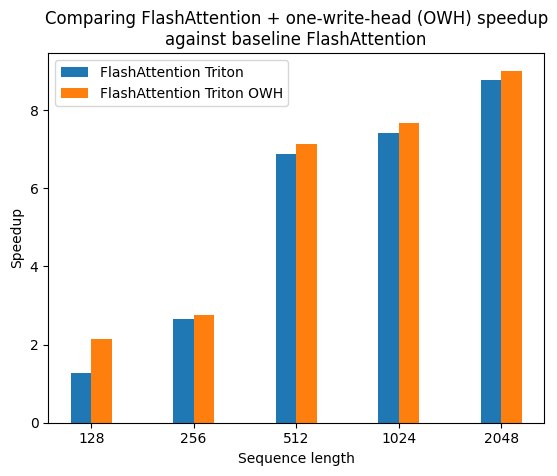

In [373]:
import matplotlib.pyplot as plt

seqlen_str=[str(v) for v in seqlen2]

ax=plt.gca()
ax.bar(x=np.arange(len(seqlen_str))-.1,height=[standardattention_time[idx]/flashattentiontriton_time[idx] for idx in range(len(seqlen_str))],width=.2)
ax.bar(x=np.arange(len(seqlen_str))+.1,height=[standardattention_time[idx]/flashattentiontritonOWH_time[idx] for idx in range(len(seqlen_str))],width=.2)
ax.set_xticks(range(len(seqlen_str)))
ax.set_xticklabels(seqlen_str)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Speedup")
ax.set_title("Comparing FlashAttention + one-write-head (OWH) speedup\nagainst baseline FlashAttention")
ax.legend(["FlashAttention Triton","FlashAttention Triton OWH"])

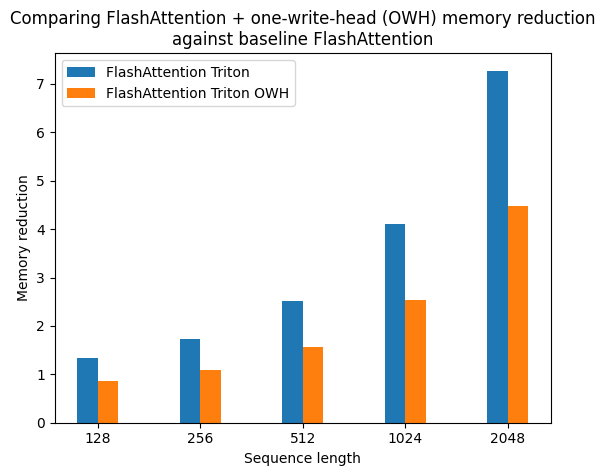

In [374]:
import matplotlib.pyplot as plt
import numpy as np

seqlen_str=[str(v) for v in seqlen2]

ax=plt.gca()
ax.bar(x=np.arange(len(seqlen_str))-.1,height=[standardattention_memory[idx]/flashattentiontriton_memory[idx] for idx in range(len(seqlen_str))],width=.2)
ax.bar(x=np.arange(len(seqlen_str))+.1,height=[standardattention_memory[idx]/flashattentiontritonOWH_memory[idx] for idx in range(len(seqlen_str))],width=.2)
ax.set_xticks(range(len(seqlen_str)))
ax.set_xticklabels(seqlen_str)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Memory reduction")
ax.set_title("Comparing FlashAttention + one-write-head (OWH) memory reduction\nagainst baseline FlashAttention")
ax.legend(["FlashAttention Triton","FlashAttention Triton OWH"])

## Testing

In [404]:
!echo "pytest --help" | docker-compose run flashattention

Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... done
== PyTorch ==

NVIDIA Release 22.12 (build 49968248)
PyTorch Version 1.14.0a0+410ce96

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Vari

In [ ]:
--capture=tee-sys

In [425]:
!echo "pytest --capture=tee-sys tests/test_flash_attn_lse.py"  | docker-compose run flashattention 

Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... done
== PyTorch ==

NVIDIA Release 22.12 (build 49968248)
PyTorch Version 1.14.0a0+410ce96

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Vari

          [True, True, True,  ..., True, True, True]]]], device='cuda:0')
causal: False
Actual dropout fraction: 0.0
Output max diff: 0.0001220703125
Output mean diff: 4.470348358154297e-06
Pytorch max diff: 0.0001220703125
Pytorch mean diff: 3.039836883544922e-06
Attention max diff: 3.814697265625e-06
Attention Pytorch max diff: 7.62939453125e-06
g_lse: tensor([[[-1348.9658,   817.2292,   495.3767,  ...,   574.6664,
            547.0305,  -408.7966],
         [  -95.9460, -1229.1782,  -816.1616,  ...,   938.4427,
          -1157.8691,   441.9395],
         [ -239.9235,  -844.6750,  -841.8685,  ...,    28.8855,
            213.7889,  1148.0608],
         [ -605.2482,  -861.6040,   108.3882,  ...,  -498.4130,
           -277.6272,   356.2944]],

        [[ 1617.9871,   871.4572, -1316.2096,  ...,   292.7500,
          -1484.9359,  -795.7991],
         [   32.1045,  -545.5378,  -626.3209,  ...,   265.7454,
          -1397.6477,   563.9579],
         [  -71.2196,  -336.8298,   371.2726,  

       device='cuda:0', dtype=torch.float16, grad_fn=<ToCopyBackward0>)
pytorch logsumexp tensor([[[6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297],
         [6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297],
         [6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297],
         [6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297]],

        [[6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297],
         [6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297],
         [6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297],
         [6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297]],

        [[6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297],
         [6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297],
         [6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297],
         [6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297]],

        ...,

        [[6.9336, 6.9336, 6.9336,  ..., 6.9297, 6.9297, 6.9297],
         [6.9336, 6.9336, 6.9336,  ..., 6.929

            0.0000e+00,  0.0000e+00]]]], device='cuda:0', dtype=torch.float16)
dq_pt_lse: tensor([[[[-9.5367e-07, -5.9605e-07,  5.9605e-07,  ..., -5.3644e-07,
            3.5763e-07,  8.3447e-07],
          [ 5.9605e-08,  1.1921e-07,  5.9605e-08,  ..., -2.3842e-07,
           -5.9605e-08,  1.7881e-07],
          [-3.5763e-07, -8.3447e-07, -1.7881e-07,  ..., -2.3842e-07,
            3.5763e-07,  0.0000e+00],
          [ 0.0000e+00,  8.9407e-07, -1.3709e-06,  ...,  3.1590e-06,
           -4.7684e-07,  1.7285e-06]],

         [[-2.9802e-07, -8.9407e-07,  3.5763e-07,  ...,  5.3644e-07,
            1.2517e-06,  1.3709e-06],
          [-2.9802e-07, -2.9802e-06, -2.9802e-07,  ..., -1.1921e-07,
            1.1921e-07,  4.7684e-07],
          [-1.5497e-06,  2.3842e-07,  5.3644e-07,  ...,  2.9802e-07,
            2.1458e-06,  1.8477e-06],
          [ 4.1723e-07, -9.5367e-07,  7.1526e-07,  ..., -2.9802e-07,
           -2.6822e-06,  1.1325e-06]],

         [[-1.7881e-07,  2.1458e-06,  4.1723e-07, 

            0.0000e+00,  0.0000e+00]]]], device='cuda:0', dtype=torch.float16)
w/ LSE dQ max diff: 9.47713851928711e-05
w/ LSE dK max diff: 2.5570392608642578e-05
w/ LSE dQ Pytorch max diff: 8.165836334228516e-06
w/ LSE dK Pytorch max diff: 6.318092346191406e-06
FActual dropout fraction: 0.0
Output max diff: 0.0001220703125
Output mean diff: 4.470348358154297e-06
Pytorch max diff: 0.0001220703125
Pytorch mean diff: 3.039836883544922e-06
Attention max diff: 3.814697265625e-06
Attention Pytorch max diff: 7.62939453125e-06
Attn shape: torch.Size([32, 4, 1024, 1024])
LSE Attn shape; torch.Size([32, 4, 1024])
LSE shape: torch.Size([32, 4, 1024])
dq_lse: tensor([[[[-0.0150, -0.0129,  0.0034,  ..., -0.0236,  0.0155, -0.0047],
          [ 0.0183, -0.0047, -0.0359,  ...,  0.0234, -0.0111, -0.0230],
          [-0.0314,  0.0134,  0.0335,  ..., -0.0105,  0.0348,  0.0276],
          [-0.0146, -0.0166, -0.0098,  ..., -0.0446,  0.0193, -0.0515]],

         [[ 0.0135,  0.0146,  0.0258,  ..., -0.0081, 

       device='cuda:0', dtype=torch.float16)
dk_lse: tensor([[[[ 1.2360e-02,  1.9241e-02, -7.2708e-03,  ..., -8.1482e-03,
            2.1398e-05,  1.8250e-02],
          [-2.7145e-02, -2.3880e-03,  2.9488e-03,  ...,  9.8419e-04,
            1.9867e-02,  1.9363e-02],
          [ 1.1734e-02, -6.4049e-03,  1.5116e-03,  ..., -1.4496e-02,
            1.1848e-02,  4.9057e-03],
          [-1.4709e-02, -1.7838e-02,  5.3253e-03,  ...,  1.6846e-02,
            2.9449e-03, -9.7961e-03]],

         [[-5.4283e-03,  7.7133e-03,  4.8943e-03,  ..., -4.2801e-03,
           -1.1152e-04,  3.8395e-03],
          [-1.8616e-02, -3.4199e-03, -1.7281e-03,  ...,  7.9651e-03,
           -1.4963e-03, -5.1041e-03],
          [-6.7825e-03, -2.4681e-03, -1.5249e-03,  ...,  2.8515e-03,
           -1.7166e-02, -1.0727e-02],
          [ 3.2253e-03, -1.7288e-02,  5.4741e-03,  ..., -1.7258e-02,
            1.1635e-02,  6.2447e-03]],

         [[-1.2062e-02, -1.5022e-02,  1.3321e-02,  ..., -1.5083e-02,
            6.4011

            0.0000e+00,  0.0000e+00]]]], device='cuda:0', dtype=torch.float16)
w/ LSE dQ Pytorch max diff: 0.000110626220703125
w/ LSE dK Pytorch max diff: 6.103515625e-05
w/ LSE dV Pytorch max diff: 0.0001220703125
FActual dropout fraction: 0.0
Output max diff: 0.0001220703125
Output mean diff: 4.470348358154297e-06
Pytorch max diff: 0.0001220703125
Pytorch mean diff: 3.039836883544922e-06
Attention max diff: 3.814697265625e-06
Attention Pytorch max diff: 7.62939453125e-06
dQ max diff: 6.103515625e-05
dK max diff: 3.0517578125e-05
dV max diff: 0.0001220703125
dQ Pytorch max diff: 6.103515625e-05
dK Pytorch max diff: 6.103515625e-05
dV Pytorch max diff: 0.0001220703125
.sssssssssssssss [ 51%]
ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss [ 58%]
ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss [ 65%]
ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss [ 71%]
ssssssssssssssssssssssssssssssssssssssssssssssssssssssssss

ERROR: 1


    """dropout_p should be set to 0.0 during evaluation
    Arguments:
        q: (total_q, nheads, headdim), where total_q = total number of query tokens in the batch.
        k: (total_k, nheads, headdim), where total_k = total number of key tokens in the batch.
        v: (total_k, nheads, headdim), where total_k = total number of key tokens in the batch.
        cu_seqlens_q: (batch_size + 1,), dtype torch.int32. The cumulative sequence lengths
           of the sequences in the batch, used to index into q.
        cu_seqlens_k: (batch_size + 1,), dtype torch.int32. The cumulative sequence lengths
           of the sequences in the batch, used to index into kv.
        max_seqlen_q: int. Maximum query sequence length in the batch.
        max_seqlen_k: int. Maximum key sequence length in the batch.
        dropout_p: float. Dropout probability.
        softmax_scale: float. The scaling of QK^T before applying softmax.
            Default to 1 / sqrt(headdim).
        causal: bool. Whether to apply causal attention mask (e.g., for auto-regressive modeling).
        return_attn_probs: bool. Whether to return the attention probabilities. This option is for
           testing only. The returned probabilities are not guaranteed to be correct
           (they might not have the right scaling).
        deterministic: bool. Whether or not to ensure deterministic execution.
    Return:
        out: (total, nheads, headdim).
        softmax_lse [optional, if return_attn_probs=True]: (batch_size, nheads, seqlen). The
            logsumexp of each row of the matrix QK^T * scaling (e.g., log of the softmax
            normalization factor).
        S_dmask [optional, if return_attn_probs=True]: (batch_size, nheads, seqlen, seqlen).
            The output of softmax (possibly with different scaling). It also encodes the dropout
            pattern (negative means that location was dropped, nonnegative means it was kept).
    """

class FlashAttnFunc(torch.autograd.Function):

    @staticmethod
    def forward(ctx, q, k, v, cu_seqlens_q, cu_seqlens_k, max_seqlen_q, max_seqlen_k, dropout_p,
                softmax_scale, causal, return_softmax, deterministic):
        if softmax_scale is None:
            softmax_scale = q.shape[-1] ** (-0.5)
        out, softmax_lse, rng_state, S_dmask = _flash_attn_forward(
            q, k, v, torch.empty_like(q), cu_seqlens_q, cu_seqlens_k, max_seqlen_q, max_seqlen_k,
            dropout_p, softmax_scale, causal=causal, return_softmax=return_softmax
        )
        ctx.save_for_backward(q, k, v, out, softmax_lse, cu_seqlens_q, cu_seqlens_k, rng_state)
        ctx.dropout_p = dropout_p
        ctx.max_seqlen_q = max_seqlen_q
        ctx.max_seqlen_k = max_seqlen_k
        ctx.softmax_scale = softmax_scale
        ctx.causal = causal
        ctx.deterministic = deterministic
        return out if not return_softmax else (out, softmax_lse, S_dmask)

    @staticmethod
    def backward(ctx, dout, *args):
        q, k, v, out, softmax_lse, cu_seqlens_q, cu_seqlens_k, rng_state = ctx.saved_tensors
        dq, dk, dv = torch.empty_like(q), torch.empty_like(k), torch.empty_like(v)
        _flash_attn_backward(
            dout, q, k, v, out, softmax_lse, dq, dk, dv, cu_seqlens_q, cu_seqlens_k,
            ctx.max_seqlen_q, ctx.max_seqlen_k, ctx.dropout_p, ctx.softmax_scale, ctx.causal,
            rng_state=rng_state, num_splits=1 if ctx.deterministic else 0,
        )
        return dq, dk, dv, None, None, None, None, None, None, None, None, None